## Per User/Session, what is the distribution of interclick times? Moreover, can we model the behavior of the user as a poisson process?

In [1]:
# imports
import pandas as pd
import pyexasol

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

host = '192.168.56.101/8A3F422F336963EBB2E452E08A6B6E7060A554D85223032A44E9C60F0EFB8544:8563'  # Don't forget to change the fingerprint
user = 'sys'
password = 'exasol'

# Connect to Exasol
conn = pyexasol.connect(dsn=host, 
                        user=user, 
                        password=password, 
                        debug=False, 
                        protocol_version=pyexasol.PROTOCOL_V1)

In [ ]:
# Get top 20 url queries, user, and time data
# Interarrival time table with properly formatted date/time
q =  '''
CREATE TABLE AOL_SCHEMA.INTERARRIVAL_TIMES AS
    SELECT 
        FACTS.ANONID,
        CAST(
        CONCAT(
            '2006-',
            LPAD(CASE 
                WHEN TIMEDIM.[day of the year] BETWEEN 60 AND 90 THEN '03'
                WHEN TIMEDIM.[day of the year] BETWEEN 91 AND 120 THEN '04'
                WHEN TIMEDIM.[day of the year] BETWEEN 121 AND 151 THEN '05'
                ELSE '01'
            END, 2, '0'), '-', 
            LPAD(TIMEDIM.[day of the month], 2, '0'), ' ',
            LPAD(TIMEDIM.[hour], 2, '0'), ':', 
            LPAD(TIMEDIM.[minute], 2, '0'), ':', 
            LPAD(TIMEDIM.[second], 2, '0')
        ) AS TIMESTAMP) AS time_as_datetime
    FROM
        AOL_SCHEMA.FACTS LEFT JOIN AOL_SCHEMA.TIMEDIM ON FACTS.TIMEID = TIMEDIM.ID
        LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
    WHERE FACTS.CLICK = 1
        AND URLDIM.URL IN (
            SELECT URLDIM.URL
            FROM AOL_SCHEMA.FACTS 
            JOIN AOL_SCHEMA.URLDIM ON AOL_SCHEMA.FACTS.URLID = AOL_SCHEMA.URLDIM.ID
            WHERE AOL_SCHEMA.FACTS.CLICK = 1
            GROUP BY URLDIM.URL
            ORDER BY COUNT(AOL_SCHEMA.FACTS.CLICK) DESC
            LIMIT 20
        )
        AND FACTS.ANONID IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[second] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
'''
conn.execute("DROP TABLE AOL_SCHEMA.INTERARRIVAL_TIMES")
conn.execute(q)




#df = printQuery(q, conn)


<ExaStatement session_id=1814606645620018945 stmt_idx=6>

In [12]:
# Obtain the anon ID's and times where there are more than 100 instances of clicking on a webpage in the top 20 most clicked webpages

q = '''
SELECT 
    T1.ANONID,
    T1.TIME_AS_DATETIME,
    COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME) AS LaggedDateTime,
    SECONDS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Seconds_Difference,
    MINUTES_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Minutes_Difference
FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T1
WHERE T1.ANONID IN (
    SELECT T2.ANONID
    FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T2
    GROUP BY T2.ANONID
    HAVING COUNT(T2.ANONID) >= 10
)

ORDER BY
    T1.ANONID,
    T1.TIME_AS_DATETIME
'''

df = printQuery(q, conn)

   ANONID            TIME_AS_DATETIME              LAGGEDDATETIME  \
0      15  2006-03-11 09:55:17.000000  2006-03-11 09:55:17.000000   
1      15  2006-03-18 21:02:45.000000  2006-03-11 09:55:17.000000   
2      15  2006-03-18 21:06:01.000000  2006-03-18 21:02:45.000000   
3      15  2006-03-21 19:55:51.000000  2006-03-18 21:06:01.000000   
4      15  2006-03-21 20:09:22.000000  2006-03-21 19:55:51.000000   

   SECONDS_DIFFERENCE  MINUTES_DIFFERENCE  
0                   0            0.000000  
1              644848        10747.466667  
2                 196            3.266667  
3              254990         4249.833333  
4                 811           13.516667  


In [15]:
df.shape
df

,ANONID,TIME_AS_DATETIME,LAGGEDDATETIME,SECONDS_DIFFERENCE,MINUTES_DIFFERENCE
0,15,2006-03-11 09:55:17.000000,2006-03-11 09:55:17.000000,0,0.000000
1,15,2006-03-18 21:02:45.000000,2006-03-11 09:55:17.000000,644848,10747.466667
2,15,2006-03-18 21:06:01.000000,2006-03-18 21:02:45.000000,196,3.266667
3,15,2006-03-21 19:55:51.000000,2006-03-18 21:06:01.000000,254990,4249.833333
4,15,2006-03-21 20:09:22.000000,2006-03-21 19:55:51.000000,811,13.516667
...,...,...,...,...,...
1028370,657399,2006-04-11 09:28:37.000000,2006-04-11 09:22:01.000000,396,6.600000
1028371,657399,2006-04-11 09:33:27.000000,2006-04-11 09:28:37.000000,290,4.833333
1028372,657399,2006-04-11 09:36:22.000000,2006-04-11 09:33:27.000000,175,2.916667
1028373,657399,2006-04-24 19:48:08.000000,2006-04-11 09:36:22.000000,1159906,19331.766667


#### Check histograms per user

(array([955.,  48.,  43.,   9.,   9.,   2.,   0.,   1.,   0.,   3.]),
 array([   0.        ,  278.23833333,  556.47666667,  834.715     ,
        1112.95333333, 1391.19166667, 1669.43      , 1947.66833333,
        2225.90666667, 2504.145     , 2782.38333333]),
 <BarContainer object of 10 artists>)

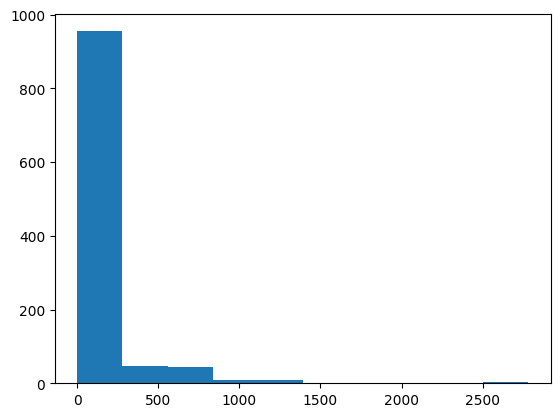

In [16]:
import matplotlib.pyplot as plt

plt.hist(df[df['ANONID'] == 42833]['MINUTES_DIFFERENCE'])

#### Concatenate all interclick times

Look at a histogram of this. Labels and title

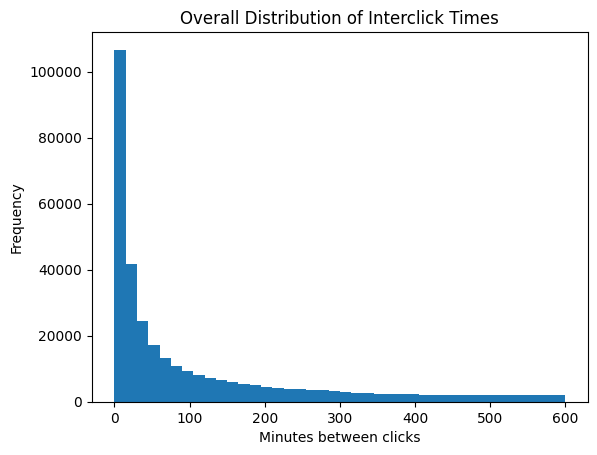

In [ ]:
# Get rid of those interclick times that are 0 and those that are more than 10 hours
plotting_df = df[df['MINUTES_DIFFERENCE'] < 600]
plotting_df = plotting_df[plotting_df['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE']

max_value = max(plotting_df)
bin_width = 15
bins = list(range(0, int(max_value) + bin_width, bin_width))
plt.hist(plotting_df, bins=bins)

plt.xlabel('Minutes between clicks')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Interclick Times')
plt.show()


#### Find the rate parameter of the distribution

In [40]:
rate = 1/plotting_df.mean()
print(rate)

rate = 1/df[df['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE'].mean()
print(rate)


0.008854968148312553
0.00023044314016607877
